# Introduction to data structures in xarray

Now that you have learned a bit of basics about raster data and how to create a simple 2-dimensional raster array using `numpy`, we continue to explore in a more comprehensive manner how to work with real-world raster data using `xarray` and `rioxarray` libraries (+ other relevant libraries linked to them). The `xarray` library is a highly useful tool for storing, representing and manipulating raster data, while `rioxarray` provides various raster processing (GIS) capabilities on top of the `xarray` data structures, such as reading and writing several different raster formats and conducting different geocomputational tasks. Under the hood, `rioxarray` uses another Python library called `rasterio` (that works with N-dimensional `numpy` arrays) but the benefit of `xarray` and `rioxarray`is that they provide easier and more intuitive way to work with raster data layers, in a bit similar manner as working with vector data using `geopandas`. 

When working with raster data, you typically have various layers that represent different geographical features of the world (e.g. elevation, temperature, precipitation etc.) and this data is possibly captured at different times of the year/day/hour, meaning that you may have longitudinal (repetitive) observations from the same area, constituting time series data. More often than not, you need to combine information from these layers to be able to conduct meaningful analysis based on the data, such as do a weather forecast. One of the greatest benefits of `xarray` is that you can easily store, combine and analyze all these different layers via a single object, i.e. a `Dataset`. 

## Key xarray datastructures: Dataset and DataArray 

The two fundamental data structures provided by the `xarray` library are `DataArray` and `Dataset` (Figure 7.2). Both of them build upon and extend the strengths of `numpy` and `pandas` libraries. The `DataArray` is a labeled N-dimensional array that is similar to `pandas.Series` but works with raster data (stored as `numpy` arrays). The `Dataset` then again is a multi-dimensional in-memory array database that contains multiple `DataArray` objects. In addition to the variables containing the observations of a given phenomena, you also have the `x` and `y` coordinates of the observations stored in separate layers, as well as metadata providing relevant information about your data, such as Coordinate Reference System and/or time. Thus, a `Dataset` containing raster data is very similar to `geopandas.GeoDataFrame` and actually various `xarray` operations can feel very familiar if you have learned the basics of `pandas` and `geopandas` covered in Chapters 3 and 6. 


![***Figure 7.2.** Key `xarray` data structures. Image source: Xarray Community (2024), licensed under Apache 2.0.*](../img/xarray-dataset-diagram.png)

***Figure 7.2** Key `xarray` data structures. Image source: [Xarray Community](https://tutorial.xarray.dev/fundamentals/01_data_structures.html) (2024), licensed under Apache 2.0.*

Some of the benefits of `xarray` include:

- A more intuitive and user-friendly interface to work with multidimensional arrays (compared e.g. to `numpy`)
- The possibility to select and combine data along a dimension across all arrays in a `Dataset` simultaneously
- Compatibility with a large ecosystem of Python libraries that work with arrays / raster data
- Tight integration of functionalities from well-known Python data analysis libraries, such as `pandas`, `numpy`, `matplotlib`, and `dask`

In the following, we will continue by introducing some of the basic functionalities of the `xarray` data structures.

## Reading a file into Dataset

We start by investigating a simple elevation dataset using `xarray` that represents a Digital Elevation Model (DEM) of Kilimanjaro area in Tanzania. To read a raster data file (such as GeoTIFF) into `xarray`, we can use the  `.open_dataset()` function. Here, we read a `.tif` file directly from a cloud storage space that we have created for this book:

In [1]:
import xarray as xr

url = "https://a3s.fi/swift/v1/AUTH_0914d8aff9684df589041a759b549fc2/PythonGIS/elevation/kilimanjaro/ASTGTMV003_S03E036_dem.tif"
data = xr.open_dataset(url, engine="rasterio")
data

<xarray.Dataset> Size: 52MB
Dimensions:      (band: 1, x: 3601, y: 3601)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 29kB 36.0 36.0 36.0 36.0 ... 37.0 37.0 37.0 37.0
  * y            (y) float64 29kB -2.0 -2.0 -2.001 -2.001 ... -2.999 -3.0 -3.0
    spatial_ref  int64 8B ...
Data variables:
    band_data    (band, y, x) float32 52MB ...

In [2]:
type(data)

xarray.core.dataset.Dataset

Now we have read the GeoTIFF file into an `xarray.Dataset` data structure which we stored into a variable `data`. The `Dataset` contains the actual data values for the raster cells, as well as other relevant attribute information related to the data:

- `Dimensions` show the number of `bands` (in our case 1), and the number of cells (3601) on the `x` and `y` axis
- `Coordinates` is a container that contains the actual `x` and `y` coordinates of the cells, the Coordinate Reference System information stored in the `spatial_ref` attribute, and the `band` attribute that shows the number of bands in our data.
- `Data variables` contains the actual data values of the cells (e.g. elevations as in our data)

Because our `Dataset` only consists of a single `band` (i.e. the elevation values), it might make sense to reduce the dimensions of our dataset by dropping the `band` attribute because it is not really providing any useful information for us. We can subset our data and remove a specific dimension from our data by using the `.squeeze()` method. In the following, we drop the `"band"` dimension:

In [3]:
data = data.squeeze("band", drop=True)
data

<xarray.Dataset> Size: 52MB
Dimensions:      (x: 3601, y: 3601)
Coordinates:
  * x            (x) float64 29kB 36.0 36.0 36.0 36.0 ... 37.0 37.0 37.0 37.0
  * y            (y) float64 29kB -2.0 -2.0 -2.001 -2.001 ... -2.999 -3.0 -3.0
    spatial_ref  int64 8B ...
Data variables:
    band_data    (y, x) float32 52MB ...

As a result, now the `Dimensions` and `Coordinates` only shows the data for `x` and `y` axis, meaning that the unnecessary data was successfully removed. 

## Renaming data variables

To make the data more intuitive to use, we can also change the name of the data variable from `band_data` into `elevation`. In this way, it is more evident what our data is about. We can easily change the name of an attibute by using the `.rename()` method as follows which wants a dictionary with syntax `{"old_name": "new_name"}`:

In [4]:
data = data.rename({"band_data": "elevation"})
data

<xarray.Dataset> Size: 52MB
Dimensions:      (x: 3601, y: 3601)
Coordinates:
  * x            (x) float64 29kB 36.0 36.0 36.0 36.0 ... 37.0 37.0 37.0 37.0
  * y            (y) float64 29kB -2.0 -2.0 -2.001 -2.001 ... -2.999 -3.0 -3.0
    spatial_ref  int64 8B ...
Data variables:
    elevation    (y, x) float32 52MB ...

Now the name of our data variable was changed to `elevation` which makes it more intuitive and convenient to use than calling the variable with a very generic name `band_data`. 

## Extracting basic raster dataset properties

One of the typical things that you want to do when exploring a new dataset is to familiarize yourself with the data at hand by examining the basic properties of the data, as well as by calculating summary statistics out of the data, such as the minimum,  maximum, or mean values of your data. To extract this information from your `Dataset`, `xarray` provides very similar functionalities as `pandas` to compute some basic statistics out of your data. For instance, we can easily extract the maximum elevation of our data by calling `.max()` method:

In [5]:
data["elevation"].max()

<xarray.DataArray 'elevation' ()> Size: 4B
array(2943., dtype=float32)
Coordinates:
    spatial_ref  int64 8B ...

As we see, this produces quite a lot of information because `xarray` returns an `DataArray` as a result by default. When exploring the output, we can see that the single value in the array is `2943` which is the highest point in our data. However, typically it would be more useful to get a numerical value as a result when doing operations like these. Luckily, it is easy to extract the actual number from the data by adding `.item()` after the command. The `.item()` method returns the `xarray.Dataset` element as a regular Python scalar value which is more similar to what e.g. `pandas` returns when you call the `.max()` or `.min()`, as demonstrated below: 

In [6]:
data["elevation"].min().item()

568.0

In [7]:
data["elevation"].max().item()

2943.0

## Converting data type



In [8]:
data["elevation"] = data["elevation"].astype("int32")
data["elevation"].max().item()

2943

In [9]:
data["elevation"].dtype

dtype('int32')

### Dimensions of the data

In addition to the summary statistics, we can explore some of the basic properties of our raster data. Majority of the geographic data related properties of a raster `Dataset` can be accessed via `.rio` {term}`accessor`. An accessor is a method or attribute added to an existing data structure, such as a `DataArray` or `Dataset` in `xarray`, to provide specialized functionality. Accessors extend the capabilities of the base object without modifying its core structure. Via the `.rio` accessor we can explore various attributes of our data, such as the `.shape`, `.width` or `.height`:

In [10]:
print(data.rio.shape)
print(data.rio.width)
print(data.rio.height)

(3601, 3601)
3601
3601


### Spatial resolution

From the outputs we can see that the shape of our raster data seems to be rectangular as we have 3601 X 3601 cells to each direction (x and y). To better understand the data in geographic terms, we can retrieve the *{term}`spatial resolution`* of the data by calling the `.rio.resolution()` method:

In [11]:
data.rio.resolution()

(0.000277777777777778, -0.000277777777777778)

As we see, the spatial resolution, i.e. the size of a single cell in our raster layer is ~0.0028. The resolution is always reported in the units of the input dataset's *{term}`coordinate reference system`* (CRS). Thus, in our case, this number is reported in *{term}`decimal degrees`* meaning that the resolution is 30 meters. 

### Coordinate reference system

We can easily access the coordinate reference system (CRS) information of our raster dataset via the `.rio.crs` attribute:

In [12]:
data.rio.crs

CRS.from_epsg(4326)

The `.rio.crs` returns the coordinate reference system information as an *{term}`EPSG code`* and the code `4326` stands for the WGS84 coordinate reference system in which the units are represented as latitudes and longitudes (i.e. decimal degrees). We will dive deeper into the coordinate reference system management with raster data in Chapter 7.4. 

### Spatial extent

To extract information about the *{term}`spatial extent`* of the dataset, we can use the `.rio.bounds()` method:

In [13]:
data.rio.bounds()

(35.9998611111111, -3.000138888888889, 37.000138888888884, -1.99986111111111)

This returns the minimum and maximum coordinates (here, in latitude and longitude) that bound our dataset, forming a minimum bounding rectangle around the data. The first two numbers represent the left-bottom (x,y) corner of the dataset, while the last two number represent the right-top corner (x,y) of the area, respectively. 

### Radiometric resolution

Lastly, we can extract information about the *{term}`radiometric resolution`* (i.e. bit depth) of our `Dataset` by calling `.dtypes`:

In [14]:
data.dtypes

Frozen({'elevation': dtype('int32')})

This returns a Python dictionary like object that provides information about the bit depth of each `DataArray` stored in our `Dataset`. In our case, we only have one data attribute (elevation) and from the result we can see that the bit depth of this data is 32 bits. The radiometric resolution is determined by the number of bits used to represent the data for each pixel, which defines the range of possible intensity values. For example, an 8-bit sensor can record 256 levels of intensity (0–255), while a 16-bit sensor can record 65,536 levels. Thus, in terms of 32-bit float, the data can be stored with high precision. 

### NoData value

TODO: Add description

In [15]:
data["elevation"].rio.nodata

## Creating a new data variable

At the moment, we only have one data variable in our `Dataset`, i.e. the `elevation`. As a reference to vector data structures in `geopandas` library which we introduced in Chapter 6, this would correspond to a situation in which you would have a single column in your `GeoDataFrame`. However, it is very easy create new data variables into your `Dataset` e.g. based on specific calculations or data conversions. For instance, we might be interested to calculate the relative height (i.e. relief) based on our data which tells how much higher the elevations (e.g. the highest peak) are relative to the lowest elevation in the area. This can be easily calculated by subtracting the lowest elevation from the highest elevation in an area. In the following, we create a new data variable called `"relative_height"` into our `Dataset` based on a simple mathematical calculation. You can create new data variables into your `Dataset` by using square brackets and the name of your variable as a string (e.g. `data["THE_NAME"]`), as follows:

In [16]:
min_elevation = data["elevation"].min().item()

# Calculate the relief
data["relative_height"] = data["elevation"] - min_elevation
data

<xarray.Dataset> Size: 104MB
Dimensions:          (x: 3601, y: 3601)
Coordinates:
  * x                (x) float64 29kB 36.0 36.0 36.0 36.0 ... 37.0 37.0 37.0
  * y                (y) float64 29kB -2.0 -2.0 -2.001 ... -2.999 -3.0 -3.0
    spatial_ref      int64 8B ...
Data variables:
    elevation        (y, x) int32 52MB 826 826 823 820 ... 1301 1301 1301 1305
    relative_height  (y, x) int32 52MB 258 258 255 252 252 ... 733 733 733 737

As a result, we now can see that a new data variable called `"relative_height"` was created and stored into our `Dataset`. All of the data variables stored in a `Dataset` are of type `DataArray` which is the N-dimensional array as we discussed at the beginning of this section. We can confirm the data type of our data variable by typing: 

In [17]:
type(data["elevation"])

xarray.core.dataarray.DataArray

Ultimately, you can store as many data variables to your dataset as you like. In case you are interested to explore all the data variables that are presented in your `Dataset`, you can do this by calling `.data_vars` attribute as follows: 

In [18]:
data.data_vars

Data variables:
    elevation        (y, x) int32 52MB 826 826 823 820 ... 1301 1301 1301 1305
    relative_height  (y, x) int32 52MB 258 258 255 252 252 ... 733 733 733 737

Here, we can see the names of the data variables, as well as some basic information about the data itself including the data type, size of the data in MiB, and a snippet of the actual values in the `DataArrays`. In case you are only interested to find out the names of the data variables, you can extract them as a list as follows:

In [19]:
list(data.data_vars)

['elevation', 'relative_height']

## Plotting a data variable

Thus far we have explored some of the basic characteristics of the `xarray` data structures. However, we have not yet plotted anything on a map, which is also one of the typical things that you want to do whenever working with new data. The `xarray` library provides very similar plotting functionality as `geopandas`, i.e. you can easily create a visualization out of your `DataArray` objects by using the `.plot()` method that uses `matplotlib` library in the background. In the following, we create a simple map out of the `"relative_height"` data variable: 

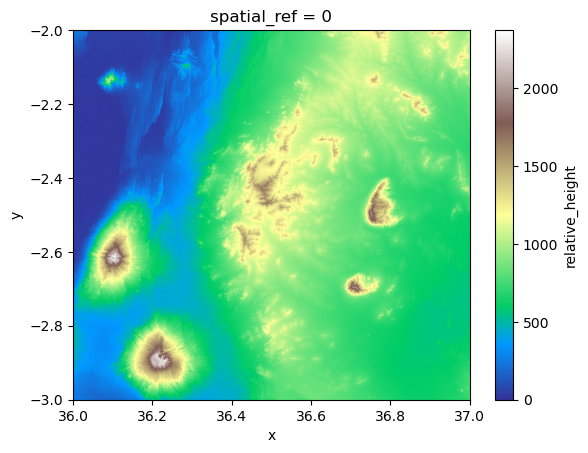

In [20]:
data["relative_height"].plot(cmap="terrain")

Great! Now we have a nice simple map that shows the relative height of the landscape where the highest peaks of the mountains are clearly visible on the bottom left corner. Notice that we used the `"terrain"` as a colormap for our visualization which provides a decent starting point for our visualization. However, as you can see it does not make sense that the part of the elevations are colored with blue because there are no values that would be below the sea surface (0 meters). It is possible to deal with this issue by adjusting the colormap which you can learn from Chapter 8. 

## Writing to a file



In [21]:
# Define the NoData value
data['elevation'].attrs['_FillValue'] = -9999

data['elevation'] = data['elevation'].astype('int16')

# Save a single DataArray as a GeoTIFF file
data["elevation"].rio.to_raster("data/temp/kilimanjaro_elevation.tif")

In [22]:
# Save a whole Dataset in NetCDF format

data.to_netcdf("data/temp/kilimanjaro_dataset.nc")

In [23]:
# Check for NaN values in the 'elevation' variable
data['elevation'].isnull().any().item()

False